<a href="https://colab.research.google.com/github/ipeirotis/dealing_with_data/blob/master/05-Time_Series/A-Introduction_to_Time_Series_using_Pandas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to Time Series and Forecasting

*Based on the book [Introduction to Time Series and Forecasting](https://link.springer.com/book/10.1007/978-3-319-29854-2) by Brockwell and Davis.*



### Learning objectives

* Recognise and plot time‑indexed data\
* Pull external macro data via API
* Diagnose autocorrelation, seasonality, trend
* Apply rolling, expanding windows and spectral tools

In [1]:
#@title Setup

!pip install -U -q PyMySQL sqlalchemy yfinance fredapi

import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
from sqlalchemy import text

from fredapi import Fred
import yfinance as yf

In [2]:
#@title Plotting Setup

%config InlineBackend.figure_format = 'retina'

# Change the graph defaults
plt.rcParams['figure.figsize'] = (8, 3)  # Default figure size of 6x2 inches
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.color'] = 'lightgray'
plt.rcParams['font.size'] = 10  # Default font size of 12 points
plt.rcParams['lines.linewidth'] = 1  # Default line width of 1 points
plt.rcParams['lines.markersize'] = 3  # Default marker size of 3 points
plt.rcParams['legend.fontsize'] = 10  # Default legend font size of 10 points

## What is a Time Series?

A time series is a set of observations $x_t$, each one being recorded at a specific time $t$. In our sessions, we focus on **_discrete_** time series, where observations are recorded at fixed time intervals (e.g., once an hour, or every 30 seconds, or every 7 days).

We only consider **_regular_** time series, where we the time between observations is constant (i.e., we do not consider account deposits or withdrawals from an ATM that happen at various times; these are examples of an irregular time series).

## Examples of Time Series



### Australian red wine sales, Jan 80 - Oct 91

The file [`australian-wine-sales.txt`](https://storage.googleapis.com/datasets_nyu/australian-wine-sales.txt) contains the monthly sales of Australian red wines in for the period Jan-1980 to Oct-1991. Let's take a peak at the data file: We will use Pandas and the `pd.read_csv` function to read the text file into a dataframe.

In [5]:
url = "https://storage.googleapis.com/datasets_nyu/australian-wine-sales.txt"
df = pd.read_csv(url, sep='\t')

##### What is this code?
# The `read_csv` command can read directly from a URL, so we pass directly
# the URL of the dataset as a parameter. Also, since the file uses the
# tab character to separate the columns, we pass the `sep='\t'` option to
# the `read_csv` command, indicating that the separator is the "tab"
# (i.e. `\t` ) character.


In [6]:
df.head(10)

,Date,Sales
0,Jan-80,464
1,Feb-80,675
2,Mar-80,703
3,Apr-80,887
4,May-80,1139
5,Jun-80,1077
6,Jul-80,1318
7,Aug-80,1260
8,Sep-80,1120
9,Oct-80,963


We can plot the time series:

<Axes: xlabel='Date'>

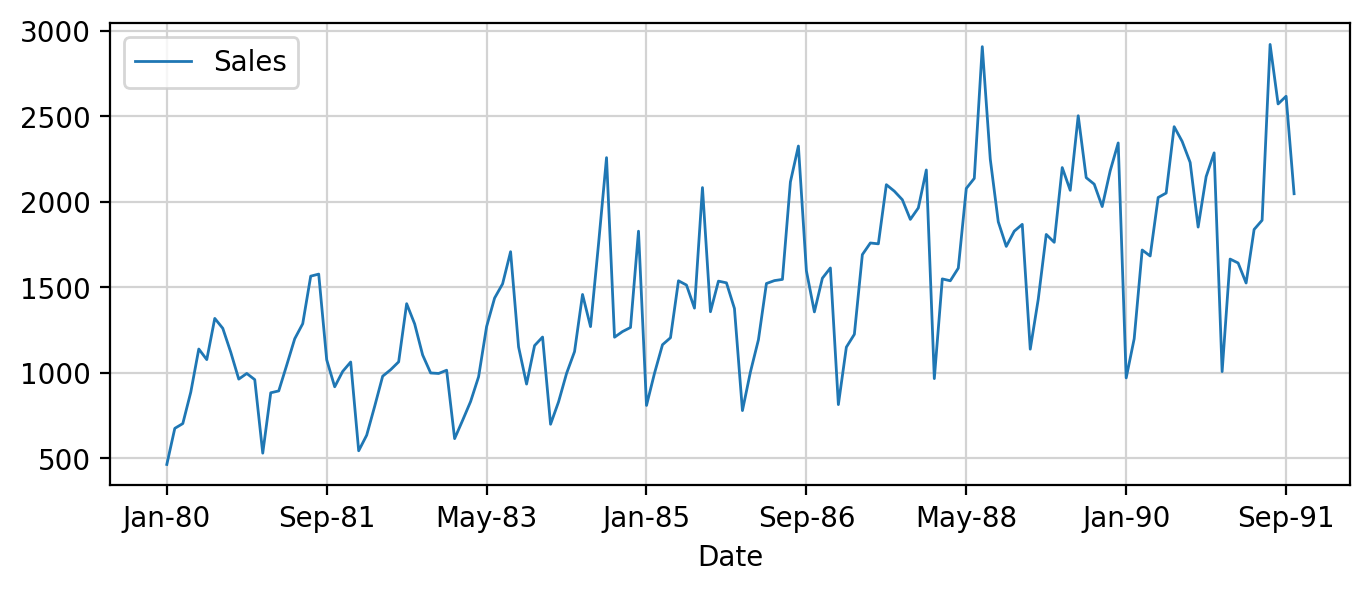

In [7]:
df.plot(
    x = 'Date',
    y = 'Sales'
)

It appears from the graph that the sales have an upward trend and a seasonal pattern with a peak in July and a trough in January.

### Typical questions in Time Series Analysis

* What is the overall trend?
* Is the current month above or below expectations?
* Do we observe any anomalies in our data?
* What should we expect for next month? Next year?

To answer such questions, we typically start by considering a few **models** of time series, and see how well such models capture the behavior of the data that we have.

For example, it is important to recognize the presence of **seasonal components** and to remove them so as not to confuse them with long-term trends. This process is known as **seasonal adjustment**.



### More Time Series

#### NYC Accidents



Taking a look at the aggregate data for NYC accidents, we can start asking questions like:

* Does the trend look good?
* When do we observe spikes in accidents on a daily and weekly basis, so that we can deploy resources accordingly? (We can also do that on a geographical basis, but we will examine that separately)
* Which dates or times are unusually high or low?

In [ ]:
# Connect to the database
conn_string = 'mysql+pymysql://{user}:{password}@{host}/?charset=utf8mb4'.format(
    host = 'db.ipeirotis.org',
    user = 'student',
    password = 'dwdstudent2025',
    encoding = 'utf8mb4')
mysql_engine = create_engine(conn_string)

# Get the number of accidents per hour
sql = '''
  SELECT date_format(DATE_TIME,'%Y-%m-%d %H:00') AS acc_date, COUNT(*) AS accidents
  FROM collisions.collisions
  GROUP BY date_format(DATE_TIME,'%Y-%m-%d %H:00')
  ORDER BY date_format(DATE_TIME,'%Y-%m-%d %H:00')
'''

# Read the results in Pandas
with mysql_engine.connect() as conn:
  acc_hourly = pd.read_sql(text(sql), con=conn)

# Convert the acc_date column to datetime
acc_hourly['acc_date'] = pd.to_datetime(acc_hourly['acc_date'])

acc_hourly.plot(
    kind='line',
    x='acc_date',
    y='accidents'
)

We can change the granularity of the time series by calculating aggregate statistics:

In [ ]:
#### NYC Accidents Daily/Weekly/Monthly

acc_aggregated = acc_hourly.copy()

# When we want to perform resampling, we need the datetime to be the "index"
acc_aggregated = acc_aggregated.set_index('acc_date')

# Modify the aggregation here to get values for daily, weekly, monthly, etc
acc_aggregated = acc_aggregated.resample('1W').sum()

# Plot the aggregated data; by default, x-axis is the index
acc_aggregated.plot(
    kind='line',
    y='accidents'
)

#### US Population

In [ ]:
# We use the thousands=',' option to properly convert the population numbers to integers
population = pd.read_csv("https://storage.googleapis.com/datasets_nyu/us-population.txt", sep=' ', thousands=',')
population["Year"] = pd.to_numeric(population["Year"])
population["US_Population"] = pd.to_numeric(population["US_Population"])

population.plot(
    kind = 'line',
    x = 'Year',
    y = 'US_Population',
    marker = 'o'
)

#### Stock prices

If you are interested in downloading stock information, [this article contains a good discussion](https://towardsdatascience.com/a-comprehensive-guide-to-downloading-stock-prices-in-python-2cd93ff821d4).

In [ ]:
stock_df = yf.download(tickers = ['GOOG','AAPL','MSFT', 'IBM'],
                       interval = '1d', # download daily prices
                       start='2005-01-01', # fetch prices after 2004
                       auto_adjust = True, # adjust for splits etc
                       progress = False # do not show a progress bar
                       )['Close'] # Keep only the closing price
stock_df

In [ ]:
stock_df.plot(
    title="Daily Closing price",
    logy=True
)

In [ ]:
# Variation of the plot, where we normalize all stocks
# by dividing the stock with the price on the first day
# of 2005.
normalized_stock_df = stock_df.copy()
first_date = normalized_stock_df.index[0]
print("First date is", first_date)

first_entry = normalized_stock_df.loc[first_date]
normalized_stock_df = normalized_stock_df / first_entry

normalized_stock_df.plot(
    title="Normalized Price (y=1 is at Jan 1 2005)",
    logy=True
)

In [ ]:
normalized_stock_df.index[0]

In [ ]:
# Daily returns
daily_returns = stock_df.pct_change(1)
daily_returns

In [ ]:
daily_returns.describe()

In [ ]:
daily_returns.plot(
    y = 'AAPL'
)

In [ ]:
daily_returns['AAPL'].hist(bins=100, color='Green', alpha=1, density=True, range=(-0.1,0.1))
daily_returns['IBM'].hist(bins=100, color='Red', alpha=0.75, density=True, range=(-0.1,0.1))

# If you want to add the KDE lines, uncomment the lines below
# daily_returns['AAPL'].plot.kde(color='Green', alpha=1, linewidth=2, xlim=(-0.1,0.1))
# daily_returns['IBM'].plot.kde(color='Red', alpha=1, linewidth=2, xlim=(-0.1,0.1))


#### Exercise

* Create a plot of the stock price for a company of your choice.
* Bechmark the stock price on Jan 1, 2020 and see the performance before and after. (Hints: (a) you can use the command .loc['1976-05-03'] to get the value of a series on a particular date; (b) there is no trading on weekends and on holidays)
* Calculate the returns of the stock on a daily basis.
* How would you calculate the return on a coarser time granularity (e.g., weekly, monthly, etc)?

In [ ]:
# Your code here

#### A more involved exercise

Here are several sector ETFs representing different areas of the economy. The ETFs below cover the 11 sectors of the Global Industry Classification Standard (GICS).

* Energy: XLE (Energy Select Sector SPDR Fund). Includes oil, gas, and renewable energy companies
* Financials: XLF (Financial Select Sector SPDR Fund). Represents banks, insurance companies, and other financial services firms
* Healthcare: XLV (Health Care Select Sector SPDR Fund). Covers pharmaceutical companies, medical device manufacturers, and healthcare providers
* Consumer Staples: XLP (Consumer Staples Select Sector SPDR Fund). Includes companies producing essential consumer goods like food, beverages, and household items
* Consumer Discretionary: XLY (Consumer Discretionary Select Sector SPDR Fund). Represents companies producing non-essential goods and services, like retail, automotive, and entertainment
* Materials: XLB (Materials Select Sector SPDR Fund). Covers companies involved in the production of raw materials, chemicals, and construction materials
* Real Estate: XLRE (Real Estate Select Sector SPDR Fund). Includes REITs and other real estate companies
* Industrials: XLI (Industrial Select Sector SPDR Fund). Represents manufacturing, aerospace, defense, and transportation companies
* Communication Services: XLC (Communication Services Select Sector SPDR Fund) Includes telecommunication, media, and entertainment companies
* Utilities: XLU (Utilities Select Sector SPDR Fund)
* Tech: XLK (Tech Select Sector SPDR Fund). Covers technology companies

***Tasks***

* Download the ETF prices since Jan 1, 2000.
* Normalize their prices and plot how the ETF prices have evolved since 2000.
* Calculate the daily returns of the ETFs.
* Use the `.describe()` command to calculate the risk profile and the returns of each sector. Which sector has performed best, which one has performed the worse?
* Use the `.corr()` to calculate the degree of correlations of the returns across sectors.
* Use the `seaborn.heatmap` to visualize the correlation matric across sectors.
* Use the `seaborn.pairplot(... kind='reg')` to create pairwise scatterplots that show the correlation of the returns using scatterplots. Here is a command that makes the regression line red, and makes the scatterplots more transparent.
`sns.pairplot(returns, kind='reg', plot_kws={'line_kws':{'color':'red'}, 'scatter_kws': {'alpha': 0.01}})`


In [ ]:
all_etf_tickers = ['XLK', 'XLU', 'XLE', 'XLF', 'XLV', 'XLP', 'XLY', 'XLB', 'XLRE', 'XLI', 'XLC']
all_etf_names = ['Tech', 'Utilities', 'Energy', 'Financials', 'Healthcare', 'Consumer Staples', 'Consumer Discretionary', 'Materials', 'Real Estate', 'Industrials', 'Communication Services']

In [ ]:
few_etf_tickers = ['XLK', 'XLRE',  'XLE', 'XLF', 'XLV']
few_etf_names = ['Tech', 'Real Estate', 'Energy', 'Financials', 'Healthcare']

In [ ]:
returns_etf.corr()

In [ ]:
g = sns.pairplot(returns_etf, kind='reg', plot_kws={'line_kws':{'color':'red'}, 'scatter_kws': {'alpha': 0.01}}, height=1.5, aspect=1)

# Iterate through the axes and set the limits
for ax in g.axes.flat:
    ax.set_xlim(-0.05, 0.05)
    ax.set_ylim(-0.05, 0.05)

#### FRED Economic Data

The [FRED Economic Data by the Federal Reserve Bank of St Louis](https://fred.stlouisfed.org/) publishes a rich set of 822,000 US and international time series from 110 sources. Here are a few examples:

In [ ]:
fred = Fred(api_key='c041995ed8b9ab9c3f475e2ca8f7c288')

In [ ]:
# Consumer Price Index for All Urban Consumers, not seasonally-adjusted
# https://fred.stlouisfed.org/series/CPIAUCNS

cpi = fred.get_series('CPIAUCNS')

In [ ]:
cpi

In [ ]:
# Access the CPI value on a specific date
print(cpi.loc['2010-01-01'])

In [ ]:
cpi.plot()

In [ ]:
# Price increases compound and increase exponentially,
# so we need log-scale to understand price increases better
# (It was the same with the stock prices)
cpi.plot(logy=True)

In [ ]:
# CPI data is monthly. The code below
# calculates the 12-month percentage change
cpi.pct_change(12).plot()

#### Normalization of time series (Exercise)

* Retrieve and plot the [Advance Retail Sales: Retail Trade and Food Services](https://fred.stlouisfed.org/series/RSAFSNA)
* Normalize the values, to account for inflation. Use the CPI time series.

* Retrieve and plot the S&P 500 index from Yahoo Finance. Its code is `'^GSPC'`; use the closing price for each date.
* To evaluate its performance in the 21st century, divide the time series with its value in January 2000. (Hints: (a) you can use the command `.loc['1976-05-03']` to get the value of a series on a particular date; (b) there is no trading on weekends and on holidays)
* Use the CPI values to examine the performance of the S&P500 after accounting for inflation. (Hint: Notice that the time series have different temporal granularity; think how to make them comparable)

## Analyzing Time Series: Autocorrelation

A commonly analyzed property of a time series is the **autocorrelation** of the sequential observations. Simply stated, a high degree of autocorrelation means that if we know the value at time $t$, we can predict well the value at $t+1$.

Using the `autocorr` function, we estimate the autocorrelation of our `Sales` time series:

In [ ]:
# Load the wine sales data
url = "https://storage.googleapis.com/datasets_nyu/australian-wine-sales.txt"
df = pd.read_csv(url, sep='\t')

# Converting the string date to proper datetime format
df["Date"] = pd.to_datetime(df["Date"])
df = df.set_index("Date")
# Ensuring that sales is a numeric variable
df["Sales"] = pd.to_numeric(df["Sales"])


In [ ]:
df["Sales"].autocorr()

The concept of autocorrelation can extend to longer time periods, and not just to $t$ and $t+1$. We can extract autocorrelation for various **lag** values.

In [ ]:
df["Sales"].autocorr(lag=1) # same as simply df["Sales"].autocorr()

In [ ]:
# Correlation between t and t+2
# ie sales now and 2 months later
df["Sales"].autocorr(lag=2)

In [ ]:
# Correlation between t and t+3
# ie sales now and 3 months later
df["Sales"].autocorr(lag=3)

### Lag plots and  autocorrelation plots

Pandas provides two types of plots that can be used for the analysis of time series: the `lag_plot` and the `autocorrelation_plot`. We can also use the seasonal decomposition functionality of `statsmodels` to separate the time series into a trend, seasonal component, and residual noise. We will go quickly over these for now, mainly for demo purposes. Proper treatment of these topics require deeper analysis.



#### Lag plot

By default, the lag plot shows the value of the series at time $t$ vs. its value at time $t+1$. If there is no dependency (i.e., the time series is noise) then the lag plot is a scatterplot without any sign of correlation. If we can see a pattern and a correlation, then the series exhibits autocorrelation. For example, below we can see that there is a rather strong correlation of the two variables, indicating that the sales in time $t+1$ is similar to the sales at time $t$.

In [ ]:
pd.plotting.lag_plot(df["Sales"], lag = 1, c='b')

In [ ]:
# The plot above shows the autocorrelation of the t and t+1
# is around 0.73
df["Sales"].autocorr(lag=1)

Here is the lag plot, where we plot $t$ and $t+12$. Notice that we have a higher correlation (less spread out points)

In [ ]:
pd.plotting.lag_plot(df["Sales"], lag = 12, c='r')

In [ ]:
df["Sales"].autocorr(lag=12)

Let's plot the two of them together.

In [ ]:
pd.plotting.lag_plot(df["Sales"], lag = 1, c='b')
pd.plotting.lag_plot(df["Sales"], lag = 12, c='r')

#### Autocorrelation Plot

In a more general setting, we want to also see if the value of the series at time $t$ is predictive of the value at time $t+n$. Such dependency would indicate that there is *autocorrelation* in the series. The autocorrelation plot shows the correlation value for various values of $n$.

In [ ]:
pd.plotting.autocorrelation_plot(df["Sales"])

The plot above, with the oscillating autocorrelation values indicate that there is a **seasonality** component in the time series. (As we see that the correlation in 12-month increments to go up and then down.)

Let's see next how we can extract the seasonal component.

### Exercise

Analyze the autocorrelation of the following series:

* NYC Accidents (`acc_hourly` and `acc_aggregated` (weekly) data frames)

* Stock prices (`normalized_stock_df` and `daily_returns`)

* Monthly CPI data from FRED (`cpi`)

## Trend and Seasonal Decomposition



In time series analysis, trend and seasonal decomposition are crucial to understand underlying patterns and recurring variations in your data. These methodologies enable better forecasting and decision-making, equipping you with a robust toolkit to leverage temporal data for business strategy. Let's dive deeper into how these methods can help us to effectively dissect and interpret our time series data.

In [ ]:
# A simple technique for decomposition.
# https://www.statsmodels.org/stable/generated/statsmodels.tsa.seasonal.seasonal_decompose.html
# Uses moving averages to calculate the trend
from statsmodels.tsa.seasonal import seasonal_decompose

# We decompose assumming a 12-month periodicity.
# We can also specify a multiplicative instead of an additive model
# The additive model is Y[t] = T[t] + S[t] + e[t]
# The multiplicative model is Y[t] = T[t] * S[t] * e[t]
decomposition = seasonal_decompose(
    x = df['Sales'],
    model='multiplicative',
    period=12,
    extrapolate_trend=24
)

In [ ]:
fig = plt.figure(figsize = (10,8))
fig = decomposition.plot(
    observed=False,
    seasonal=True,
    trend=True,
    resid=True,
)

#### Accessing indinvidual components of the decomposition

Once we have the decomposed time series model, we can also access the different components.

For example, we can get the trend of the time series, after removing the seasonality component:

In [ ]:
# The outcome is a pandas Series, which is effectively the same as a single column of dataframe
decomposition.trend

In [ ]:
decomposition.trend.plot()

#### Periodogram (optional, advanced)

The periodogram is a graph that identifies the most important periodicities in the data. **We typically apply that to a timeseries with zero trend**. After that, we can extract the time periods to consider for periodicities. For most data, daily, weekly, and yearly are the three periods that we consider. In rare cases, a periodogram will reveal additional patterns.

In [ ]:
import numpy as np
from scipy.signal import periodogram
import matplotlib.pyplot as plt

# Create  a periodogram from the detrended sales time series
timeseries = df["Sales"] / decomposition.trend
freqs, psd = periodogram(timeseries)

# Create a dataframe with the results, and convert
# frequencies to time between events (periods)
# Remember that frequency = time per unit time (eg "2 times per month")
# and period is the inverse (e.g., "every half month")
prd = pd.DataFrame({"freqs": freqs, "psd": psd})
prd['period'] = 1/prd['freqs']

# Plot the results. Often people do a log on the y-axis, but
# for identifying the major components, I think that linear works
# better
prd.plot(
    x='period',
    y = 'psd',
    ylabel = 'Power Spectral Density',
    logx=True,
    # logy=True
)

## Exercise

* Below we fetch the daily number of vehicular accidents in NYC.
* Examine the autocorrelation structure of the accidents.
* Perform a decomposition of the time series into a trend, seasonal, and residual component.
* Try out both the additive and the multiplicative approach for the decomposition. Try to interpret and understand the difference in the reported seasonal component.
* Instead of counting accidents, extract the number of injuries and perform the same analysis.

In [ ]:
conn_string = 'mysql+pymysql://{user}:{password}@{host}/{db}?charset=utf8mb4'.format(
    host = 'db.ipeirotis.org',
    user = 'student',
    password = 'dwdstudent2025',
    db = 'collisions',
    encoding = 'utf8mb4')

mysql_engine = create_engine(conn_string)

sql = '''
  SELECT date_format(DATE_TIME,'%Y-%m-%d') AS acc_date, COUNT(*) AS accidents
  FROM collisions.collisions
  GROUP BY date_format(DATE_TIME,'%Y-%m-%d')
  ORDER BY date_format(DATE_TIME,'%Y-%m-%d')
'''

with mysql_engine.connect() as conn:
  acc = pd.read_sql(text(sql), con=conn)
acc['acc_date'] = pd.to_datetime(acc['acc_date'])
acc = acc.set_index('acc_date')

In [ ]:
acc.plot()

In [ ]:
# Examine the autocorrelation

### Solution

In [ ]:
acc['accidents'].autocorr()

In [ ]:
acc['accidents'].autocorr(lag=2)

In [ ]:
acc['accidents'].autocorr(lag=7)

In [ ]:
acc['accidents'].autocorr(lag=365)

In [ ]:
pd.plotting.lag_plot(acc['accidents'], lag = 1, c='b', s=1)

In [ ]:
pd.plotting.lag_plot(acc['accidents'], lag = 7, c='b', s=1)

In [ ]:
pd.plotting.autocorrelation_plot(acc['accidents'])

In [ ]:
plot = pd.plotting.autocorrelation_plot(acc['accidents'])
plot.set_xlim(0,90)

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

# We decompose assumming a 12-month periodicity.
# We can also specify a multiplicative instead of an additive model
# The additive model is Y[t] = T[t] + S[t] + e[t]
# The multiplicative model is Y[t] = T[t] * S[t] * e[t]

period = 7 # We have daily observations, and we consider one week
             # as the seasonality period
decomposition = seasonal_decompose(x = acc['accidents'],
                                   model='multiplicative',
                                   period=period,
                                   extrapolate_trend=period
                )

fig = plt.figure(figsize = (10,8))
fig = decomposition.plot(
    observed=False,
    seasonal=True,
    trend=True,
    resid=True,
)

In [ ]:
# Plot the trend
decomposition.trend.plot()

In [ ]:
# Plot the seasonal component for the first week of the data
decomposition.seasonal.head(period).plot(figsize=(10,3))

In [ ]:
# Plot the residual
decomposition.resid.plot(figsize=(10,3))

In [ ]:
# Identify the dates with the highest/lowest
# residual  components
decomposition.resid.sort_values()

In [ ]:
decomposition.resid.sort_values().head(10)

In [ ]:
decomposition.resid.sort_values().tail(10)

In [ ]:
# Examine the autocorrelation structure of the residuals
ax = pd.plotting.autocorrelation_plot(decomposition.resid, linewidth=1)
ax.set_xlim( [0,365] )
pass

## Advanced: Time Series Window operations: Rolling / Expanding / EW

One question that comes up when we have a periodic time series is: "How can I figure out the overall trend?". In the examples above, we relied on a "black box" where we simply asked for the time series to be decomposed into a trend, seasonal, and residual component. Now, let's dig a bit deeper on how we can extract trend components that are unaffected by seasonality.

For that, we often rely on "window" functions, that operate over a set of continuous time series points. For example, if we have a time series that has a 12-month seasonality, we can take the 12-month average, which will not exhibit seasonality, but will capture the trend.

These windows functions are common time series operations. Pandas provides support for various types of windows. Here are a few that are commonly used:
* [Rolling window](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.rolling.html): We compute the function over a time period equal to a window
* [Expanding](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.expanding.html): We compute the function over a period of 1, 2, 3,... instances.
* [Exponential weighting](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.ewm.html): We keep a window of a fixed size but we weight less and less (exponentially) the old data points.

In [ ]:
# Use different linestyle, and use high alpha to make the series less visually prominent
df['Sales'].plot(label='Raw', linestyle ="--", alpha=0.25)

# Plot the 12-month moving average
df['Sales'].rolling(12).mean().plot(label='12M MA', alpha=0.75)

# Plot the expanding mean. This is the mean of the series from the beginning till that point in time
df['Sales'].expanding().mean().plot(label='Expanding', alpha=0.75)

# Plot the exponentially weighted moving average. This moving average weighs more heavily the newer
# data points and weighs less the old ones.
df['Sales'].ewm(halflife=12).mean().plot(label='EWMA (halflife 12M)', alpha=0.75)

# places the legend to the right side (1) and middle of the y-axis (0.5)
plt.legend(bbox_to_anchor=(1, .5))
plt.tight_layout()